This notebook uses Foolbox to generate adversarial examples for either MNIST or Inception-V3. 'net' decides which it will do so for, while 'batch' is how many adversarial examples to find. (Warning: I imagine it would take a while for Inception without a GPU, so I would recommend a small number at first)

Foolbox has up to 20 examples for these datasets stored. Not all of these images are originally classified correctly. 

For MNIST, the attack being used is GenAttack, a decision-based attack.  
For Inception-V3, the attack being used is DeepFool, a quite fast and powerful gradient-based attack. 

The following link lists more attacks and more information. You should be able to switch them out for one of the two attacks below (depending on if the new attack is only targeted/untargeted.  
https://foolbox.readthedocs.io/en/latest/modules/attacks.html

In [1]:
net = 2 # 1 - MNIST, 2 - Inception-V3
batch = 10 # how many adversarial examples to find

In [2]:
# Import Time
import random, time, foolbox, torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

%matplotlib inline

# Foolbox defaults to a GPU

In [3]:
# MNIST network
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # image starts as (1, 28, 28)
        # Formula to compute size of image after conv/pool
        # (size-filter+2*padding / stride) + 1
        #                      inputs         # of filters    filter size    
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2) # conv1
        self.conv1_bn = nn.BatchNorm2d(num_features=32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2) # conv2
        self.conv2_bn = nn.BatchNorm2d(num_features=64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels= 128, kernel_size=3, stride=1, padding=1) # conv3
        self.conv3_bn = nn.BatchNorm2d(num_features=128)
        
        self.fc1 = nn.Linear(in_features=128*6*6, out_features=1024) # linear 1
        self.fc1_bn = nn.BatchNorm1d(num_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=512) # linear 2
        self.fc2_bn = nn.BatchNorm1d(num_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=256) # linear 3
        self.fc3_bn = nn.BatchNorm1d(num_features=256)
        self.fc4 = nn.Linear(in_features=256, out_features=64) # linear 4
        self.fc4_bn = nn.BatchNorm1d(num_features=64)
        self.out = nn.Linear(in_features=64, out_features=10) # output
    
    def forward(self, t):
        t = F.relu(self.conv1_bn(self.conv1(t)))
        t = F.max_pool2d(t, kernel_size=2, stride=2) # (1, 14, 14)
        
        t = F.relu(self.conv2_bn(self.conv2(t)))
        t = F.max_pool2d(t, kernel_size=2, stride=2) # (1, 7, 7)
        
        t = F.relu(self.conv3_bn(self.conv3(t)))
        t = F.max_pool2d(t, kernel_size=2, stride=1) # (1, 6, 6)
        
        t = F.relu(self.fc1_bn(self.fc1(t.reshape(-1, 128*6*6))))
        t = F.relu(self.fc2_bn(self.fc2(t)))
        t = F.relu(self.fc3_bn(self.fc3(t)))
        t = F.relu(self.fc4_bn(self.fc4(t)))
        t = self.out(t)
        
        return t

In [4]:
# sets a bunch of variables
if net == 1:
    network = Network()
    network.load_state_dict(torch.load("mnist_example.pt"))
    dataset = 'mnist'
    channels = 1
    size = 28
    classes = 10
elif net == 2:
    network = models.inception_v3(pretrained=True)
    dataset = 'imagenet'
    channels = 3
    size = 224
    classes = 1000
network.eval();

# The Attack Part

In [5]:
# Foolbox time 
# Convert the model to a foolbox model
fnetwork = foolbox.models.PyTorchModel(network, bounds=(0, 1), num_classes=classes, channel_axis=1) # model

# get source image and label
# images are just an array
images, labels = foolbox.utils.samples(dataset=dataset, batchsize=batch, data_format='channels_first', bounds=(0, 1))
images = images.reshape(batch, channels, size, size)

print(images.shape)
print(labels)
print(fnetwork.forward(images).argmax(axis=-1)) # original prediction
print("Accuracy: ", np.mean(fnetwork.forward(images).argmax(axis=-1) == labels)) 

(10, 3, 224, 224)
[243 559 438 990 949 853 609 609 915 455]
[243 532 438 121 949 853 609 436 915 455]
Accuracy:  0.7


In [6]:
if net == 1:
    attack = foolbox.attacks.GenAttack(fnetwork, distance=foolbox.distances.Linfinity, 
                                       criterion=foolbox.criteria.TargetClass(8)) 
elif net == 2:
    attack = foolbox.attacks.DeepFoolL2Attack(fnetwork, distance=foolbox.distances.Linfinity)

t1 = time.time()
adversarials = attack(images, labels,  unpack=False) # get the adversarial examples
t2 = time.time()

avg_time = (t2 - t1) / batch
print("Avg Time: ", avg_time)

Avg Time:  0.325621509552002


In [7]:
# this cell & next 2 are mostly from a foolbox tutorial
adversarial_classes = np.asarray([a.adversarial_class for a in adversarials])
print("Labels: ", labels)
print("Adv. Labels: ", adversarial_classes)
print("Classification Acc: ", np.mean(adversarial_classes == labels)) # should be 0.0

Labels:  [243 559 438 990 949 853 609 609 915 455]
Adv. Labels:  [180 532 617 121 927 706 586 436 970 108]
Classification Acc:  0.0


In [8]:
_sum = 0
for i in range(batch):
    _sum += adversarials[i].distance.value
avg_Linf = _sum / batch
print("Avg L-inf: ", avg_Linf)

Avg L-inf:  0.09080212712287902


In [9]:
# The 'Adversarial' objects also provide a 'distance' attribute. Note that the distances
# can be 0 (misclassified without perturbation) and inf (attack failed).
distances = np.asarray([a.distance.value for a in adversarials])
print("{:.1e}, {:.1e}, {:.1e}".format(distances.min(), np.median(distances), distances.max()))
print("{} of {} attacks failed".format(sum(adv.distance.value == np.inf for adv in adversarials), len(adversarials)))
print("{} of {} inputs misclassified without perturbation".format(sum(adv.distance.value == 0 for adv in adversarials), len(adversarials)))

0.0e+00, 7.3e-02, 2.5e-01
0 of 10 attacks failed
3 of 10 inputs misclassified without perturbation


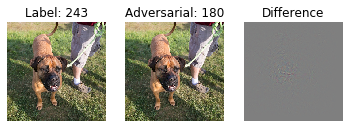

C:\Users\Joseph\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


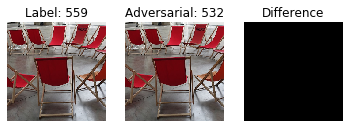

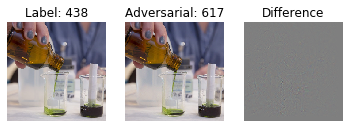

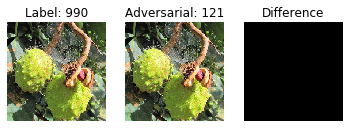

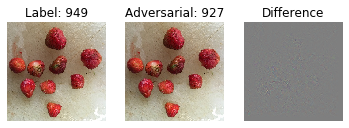

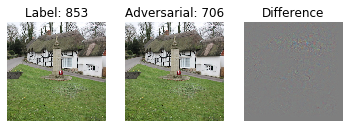

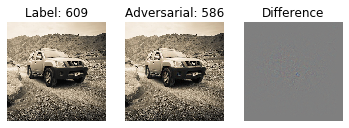

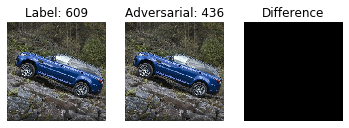

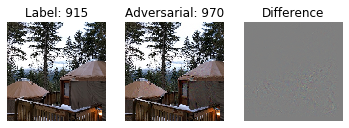

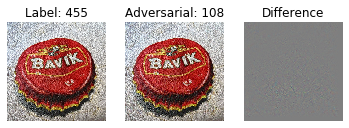

In [10]:
# Some plotting 
for i in range(batch):

    image = images[i]
    adversarial = adversarials[i].perturbed

    # CHW to HWC (switching the channels)
    image = image.transpose(1, 2, 0)
    adversarial = adversarial.transpose(1, 2, 0)
    if image.shape[2] == 1: # for MNIST (only one color channel)
        image = image.reshape(28, 28)
        adversarial = adversarial.reshape(28, 28)
    
    plt.figure()

    # Original
    plt.subplot(1, 3, 1)
    plt.title('Label: '+ str(labels[i]))
    plt.imshow(image)
    plt.axis('off')

    # Adversarial
    plt.subplot(1, 3, 2)
    plt.title('Adversarial: ' + str(adversarials[i].adversarial_class))
    plt.imshow(adversarial)
    plt.axis('off')

    # Difference
    plt.subplot(1, 3, 3)
    plt.title('Difference')
    difference = adversarial - image
    plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
    plt.axis('off')

    plt.show()

If the difference is black, then the original image was misclassified. The adversarial labels for those images matches the original prediction above. 